In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
vector.register_awkward() 

In [3]:
SAMPLE_RUNS = sorted([290323, 290327, 290848, 291361, 291360, 291362, 290853, 290860, 291373, 290374, 
                      290375, 291399, 291400, 290894, 290895, 290404, 291943, 291944, 291948, 291953, 
                      290932, 290423, 291447, 290935, 290425, 290427, 291451, 291453, 291976, 291982, 
                      290456, 290458, 290459, 291482, 291485, 290975, 290980, 290469, 292012, 291002, 
                      291003, 291004, 291005, 290501, 292040, 292060, 292061, 292062, 291041, 290539, 
                      290540, 292075, 292077, 292080, 290549, 290553, 291590, 292106, 292108, 292109, 
                      292115, 290590, 291618, 291622, 291624, 292140, 290612, 292160, 292162, 292163, 
                      292164, 292166, 290632, 291657, 292168, 292192, 290658, 290660, 291690, 291692, 
                      291694, 291698, 291706, 290687, 290692, 290696, 290699, 292242, 292265, 291755, 
                      292269, 292270, 291760, 292273, 292274, 290742, 291769, 291263, 290764, 290766, 
                      291283, 291284, 291285, 291795, 291796, 290776, 291803, 290787])

In [175]:
def integral(histo: hist.Hist, start: float, stop: float):
    start_bin = histo.axes[0].index(start)  
    stop_bin = histo.axes[0].index(stop)
    return histo[start_bin:stop_bin].sum()

def getTracksEvents(events):
    return ak.zip({
        "px":events["Muon_Px"],
        "py":events["Muon_Py"],
        "pz":events["Muon_Pz"],
        "E":events["Muon_E"],
        "charge":events["Muon_Charge"],
        "thetaAbs":events["Muon_thetaAbs"],
        "matched":events["Muon_matchedTrgThreshold"],
        "code":events["Muon_MCPDGCode"],
        "label":events["Muon_MCLabel"]},
         with_name='Momentum4D')

def getTracksGen(events):
    return ak.zip({
        "px":events["Muon_GenPx"],
        "py":events["Muon_GenPy"],
        "pz":events["Muon_GenPz"],
        "E":events["Muon_GenE"],
        "label":events["Muon_GenLabel"],
        "code":events["Muon_GenMotherPDGCode"]},
        with_name='Momentum4D')

def Momentum4D(events):
    return ak.zip({
        "px": events["0"].px + events["1"].px,
        "py": events["0"].py + events["1"].py,
        "pz": events["0"].pz + events["1"].pz,
        "E" : events["0"].E  + events["1"].E},
        with_name="Momentum4D")


def scan(dataDescription, 
              hMagGen:hist.Hist, hPhiGen:hist.Hist, hEtaGen:hist.Hist, hYGen:hist.Hist, hPtGen:hist.Hist, hMassGen:hist.Hist, hMass2Gen:hist.Hist,
              hMagEvents:hist.Hist, hPhiEvents:hist.Hist, hEtaEvents:hist.Hist, hYEvents:hist.Hist, hPtEvents:hist.Hist, hMassEvents:hist.Hist, hMass_OSMuon:hist.Hist, hMass_LSMuon:hist.Hist,
              eventSelectorGen = lambda x:[True]*len(x), trackSelectorGen = lambda x:[True]*len(x), pairSelectorGen = lambda x:[True]*len(x),
              eventSelectorEvents = lambda x:[True]*len(x), trackSelectorEvents = lambda x:[True]*len(x), pairSelectorEvents = lambda x:[True]*len(x),
              verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    
    nEntriesGen = nGoodEventsGen = nGoodTracksGen = nGoodEntriesGen = nJPsiGen = nPairsGen = nGoodGen= 0
    PDGGen = PDG = LabelGen = Label = []
    nEntries = nGoodEvents = nGoodTracks = nGoodEntries = AxE = nPairs = nOS = nGoodOS = nLS = nGoodLS = nJPsiEvents = 0
    
    for batchGen, batchEvents in zip(uproot.iterate(dataDescription + "genTree", ["Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel", "Muon_GenMotherPDGCode"], report = True),
                                    uproot.iterate(dataDescription + "eventsTree", ["isCINT", "isCMUL", "isCMSL", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge", "Muon_thetaAbs", "Muon_matchedTrgThreshold", "Muon_MCLabel", "Muon_MCPDGCode"], report = True)):

        eventsGen = batchGen[0] # batch[1] is the report info
        events = batchEvents[0]
        #eventsGen[0:10].show()
        #events[0:10].show()

        if (len(eventsGen) < 1000) | (len(events) < 1000):
            print("something is wrong", batchGen[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEventsGen = eventsGen[eventSelectorGen(eventsGen)]
        tracksGen = getTracksGen(goodEventsGen)
        goodTracksGen = tracksGen[trackSelectorGen(tracksGen)]
        #goodTracksGen[0:10].show()
        
        hMagGen.fill(ak.flatten(goodTracksGen.p))
        hPhiGen.fill(ak.flatten(goodTracksGen.phi))
        hPtGen.fill(ak.flatten(goodTracksGen.pt))
        hEtaGen.fill(ak.flatten(goodTracksGen.eta))
        hMassGen.fill(ak.flatten(goodTracksGen.mass))
        
        pairsGen = ak.combinations(goodTracksGen, 2)
        #pairsGen[0:10].show()
        Gen = Momentum4D(pairsGen)
        #Gen[0:10].show()
        goodGen = Gen[pairSelectorGen(Gen)]
        #goodGen[0:10].show()
        
        hMass2Gen.fill(ak.flatten(goodGen.mass))
        hYGen.fill(ak.flatten(goodGen.rapidity))
        
        
        
        isJPsi = ak.num(goodTracksGen) > 0
        #print(isJPsi[0:10].show())
        events2 = ak.zip({"isJPsi":isJPsi, "isCINT":events["isCINT"], "isCMUL":events["isCMUL"], "isCMSL":events["isCMSL"], "Muon_Px":events["Muon_Px"], "Muon_Py":events["Muon_Py"], 
                          "Muon_Pz":events["Muon_Pz"], "Muon_E":events["Muon_E"], "Muon_Charge":events["Muon_Charge"], "Muon_thetaAbs":events["Muon_thetaAbs"],
                          "Muon_matchedTrgThreshold":events["Muon_matchedTrgThreshold"], "Muon_MCLabel":events["Muon_MCLabel"], "Muon_MCPDGCode":events["Muon_MCPDGCode"]})
                          
        
        #print(events2[0:10].show())
        goodEvents = events2[eventSelectorEvents(events2)]
        tracks = getTracksEvents(goodEvents)
        goodTracks = tracks[trackSelectorEvents(tracks)]
        #goodTracks[0:10].show()
        
        
        pairs = ak.combinations(goodTracks, 2)
        
        condition_OS = np.logical_or(np.logical_and(pairs["0"].code ==  13, pairs["1"].code == -13),
                                     np.logical_and(pairs["0"].code == -13, pairs["1"].code ==  13))
        muons_OS = pairs[condition_OS]
        OS = Momentum4D(muons_OS)
        goodOS = OS[pairSelectorEvents(OS)]
    
        
        condition_LS = np.logical_or(np.logical_and(pairs["0"].code == -13, pairs["1"].code == -13),
                                     np.logical_and(pairs["0"].code ==  13, pairs["1"].code ==  13))
        muons_LS = pairs[condition_LS]
        LS = Momentum4D(muons_LS)
        goodLS = LS[pairSelectorEvents(LS)]

        
        hMagEvents.fill(ak.flatten(goodTracks.p))
        hPtEvents.fill(ak.flatten(goodTracks.pt))
        hPhiEvents.fill(ak.flatten(goodTracks.phi))
        hEtaEvents.fill(ak.flatten(goodTracks.eta))
        hMassEvents.fill(ak.flatten(goodTracks.mass))
        
        hYEvents.fill(ak.flatten(goodOS.rapidity))
        hMass_OSEvents.fill(ak.flatten(goodOS.mass))
        hMass_LSEvents.fill(ak.flatten(goodLS.mass))
        
        
        nEntriesGen += len(eventsGen)
        nGoodEventsGen += len(goodEventsGen)
        nGoodTracksGen += len(ak.flatten(goodTracksGen))
        nGoodEntriesGen += list(ak.num(goodTracksGen) > 0).count(True)
        nPairsGen += len(ak.flatten(pairsGen))
        nGoodGen += len(ak.flatten(goodGen))
        PDGGen = np.union1d(PDG, ak.flatten(goodTracksGen.code))
        LabelGen = np.union1d(LabelGen, ak.flatten(goodTracksGen.label))
        
        nEntries += len(events)
        nGoodEvents += len(goodEvents)
        nGoodTracks += len(ak.flatten(goodTracks))
        nGoodEntries += list(ak.num(goodTracks) > 0).count(True)
        nPairs += len(ak.flatten(pairs))
        nOS += len(ak.flatten(OS))
        nGoodOS += len(ak.flatten(goodOS))
        nLS += len(ak.flatten(LS))
        nGoodLS += len(ak.flatten(goodLS))
        PDG = np.union1d(PDG, ak.flatten(goodTracks.code))
        Label = np.union1d(Label, ak.flatten(goodTracks.label))
        
        nJPsiEvents += len(ak.flatten(goodOS))
        nJPsiGen += len(ak.flatten(goodGen))
        AxE = nJPsiEvents / nJPsiGen
        err = np.sqrt((1 / nJPsiGen)**2 * (np.sqrt(nJPsiEvents))**2  +  (-nJPsiEvents / nJPsiGen**2)**2 * (np.sqrt(nJPsiGen))**2)

        if verbose:
            #print("Statistiques Generees")
            print(batchGen[1])
            print("Entries: ", nEntries)
            print("Good Events: ", nGoodEventsGen)
            print("Good Tracks: ", nGoodTracksGen)
            print("Good Entries: ", nGoodEntriesGen)
            print("Pairs: ", nPairsGen)
            print("Good Pairs: ", nGoodGen)
            #print("PDG: ", PDGGen)
            #print("Label: ", LabelGen)
            print("----------------------------")
            
            #print("Statistiques Detectees")
            print(batchEvents[1])
            print("Entries: ", nEntries)
            print("Good Events: ", nGoodEvents)
            print("Good Tracks: ", nGoodTracks)
            print("Good Entries: ", nGoodEntries)
            print("Pairs: ", nPairs)
            print("OS: ", nOS)
            print("Good OS:", nGoodOS)
            #print("LS: ", nLS)
            #print("Good LS:", nGoodLS)
            #print("PDG: ", PDG)
            #print("Label: ", Label)
            print("----------------------------")
            
            print("J/Psi gen: ", nJPsiGen)
            print("J/Psi events: ", nJPsiEvents)
            #print("-------> AxE: ", AxE, " +/- ", err, "(stat.)")
            print("---------------------------------------------------------------------------------------")
        gc.collect()
        
    return nEntriesGen, nGoodEventsGen, nGoodTracksGen, nGoodEntriesGen, nJPsiGen, nPairsGen, nGoodGen, PDGGen, LabelGen, nEntries, nGoodEvents, nGoodTracks, nGoodEntries, nPairs, nOS, nGoodOS, nLS, nGoodLS, PDG, Label, AxE, nJPsiEvents, err

In [237]:
%%time

hMagGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiGen = hist.Hist(hist.axis.Regular(bins = 200, start = -np.pi, stop = np.pi, name = '$\phi$'))
hEtaGen = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hPtGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMassGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))
hYGen = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hMass2Gen = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

hMagEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiEvents = hist.Hist(hist.axis.Regular(bins = 200, start = -np.pi, stop = np.pi, name = '$\phi$'))
hEtaEvents = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hPtEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMassEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))
hYEvents = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hMass_OSEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LSEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

EntriesGen = goodEventsGen = goodTracksGen = goodEntriesGen = JPsiGen = PairsGen = goodGen = 0
PDGGen = PDG = LabelGen = Label = []
Entries = goodEvents = goodTracks = goodEntries = Pairs = OS = goodOS = LS = goodLS = JPsiEvents = 0
numerator = denominator = AxE = err_num = err_den = err = 0

runs = SAMPLE_RUNS
_ = pd.read_csv("../data/counters.online.csv")
target_columns = ["run", "duration(s)"]
runDurationWeight = _[target_columns]
filtered_runDurationWeight = runDurationWeight[runDurationWeight["run"].isin(runs)]
filtered_runDurationWeight = filtered_runDurationWeight.copy()
filtered_runDurationWeight["weight"] = filtered_runDurationWeight["duration(s)"] / filtered_runDurationWeight["duration(s)"].max()

for run, duration, weight in filtered_runDurationWeight.values:
    a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w = scan(dataDescription = f"/pbs/throng/training/nantes-m2-rps-exp/data/run{int(run)}.mc.root:",
                                                                                    hMagGen = hMagGen, hPhiGen = hPhiGen, hEtaGen= hEtaGen, hYGen = hYGen, hPtGen = hPtGen, hMassGen = hMassGen, hMass2Gen = hMass2Gen,
                                                                                    hMagEvents = hMagEvents, hPhiEvents = hPhiEvents, hEtaEvents = hEtaEvents, hYEvents = hYEvents, hPtEvents = hPtEvents, hMassEvents = hMassEvents, hMass_OSMuon = hMass_OSEvents, hMass_LSMuon = hMass_LSEvents,
                                                                                    #eventSelectorGen = lambda x: ,
                                                                                    trackSelectorGen = lambda x: ((x.label == 1) | (x.label == 2)) & (x.code == 443),
                                                                                    pairSelectorGen = lambda x: (x.rapidity > -4.0) & (x.rapidity < -2.5) & (x.pt > 0) & (x.pt < 1),
                                                                                    eventSelectorEvents = lambda x: (x["isJPsi"] == True) & (x["isCMUL"] == True),
                                                                                    trackSelectorEvents = lambda x: ((x.code == 13) | (x.code == -13)) & ((x.label == 1) | (x.label == 2)) & (x.eta > -4.0) & (x.eta < -2.5) & (x.thetaAbs > 2) & (x.thetaAbs < 10) & (x.pt > 0.5),# & (x.matched == 2),
                                                                                    pairSelectorEvents = lambda x: (x.rapidity > -4.0) & (x.rapidity < -2.5) & (x.pt > 0) & (x.pt < 1),
                                                                                    verbose = True)
    
    EntriesGen += a
    goodEventsGen += b
    goodTracksGen += c
    goodEntriesGen += d
    PairsGen += f
    goodGen += g
    PDGGen = np.union1d(PDGGen, h)
    LabelGen = np.union1d(LabelGen, i)
    
    Entries += j
    goodEvents += k
    goodTracks += l
    goodEntries += m
    Pairs += n
    OS += o
    goodOS += p
    LS += q
    goodLS += r
    PDG = np.union1d(PDG, s)
    Label = np.union1d(Label, t)
    
    JPsiGen += e
    JPsiEvents += v
    
    numerator += weight * u
    denominator += weight
    err_num += weight * w
    err_den += weight
    
    print("run: ", int(run))
    print("Duration(s): ", int(duration))
    print("Weight: ", weight)
    print("-------> AxE: ", u, " +/- ", w, "(stat.)")
    print("---------------------------------------------------------------------------------------")
    
AxE = numerator / denominator
err = err_num / err_den

print("Entries: ", EntriesGen)
print("Good Events: ", goodEventsGen)
print("Good Tracks: ", goodTracksGen)
print("Good Entries: ", goodEntriesGen)
print("Pairs: ", PairsGen)
print("Good Pairs: ", goodGen)
print("PDG: ", PDGGen)
print("Label: ", LabelGen)
print("----------------------------")
print("Entries: ", Entries)
print("Good Events: ", goodEvents)
print("Good Tracks: ", goodTracks)
print("Good Entries: ", goodEntries)
print("Pairs: ", Pairs)
print("OS: ", OS)
print("Good OS: ", goodOS)
print("LS: ", LS)
print("Good LS: ", goodLS)
print("PDG: ", PDG)
print("Label: ", Label)
print("----------------------------")
print("J/Psi gen: ", JPsiGen)
print("J/Psi events: ", JPsiEvents)
print("-------> AxE: ", AxE, " +/- ", err, "(stat.)")
print("---------------------------------------------------------------------------------------")

<Report start=0 stop=70000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.mc.root:/genTree;1'>
Entries:  70000
Good Events:  70000
Good Tracks:  54684
Good Entries:  40807
Pairs:  13877
Good Pairs:  1852
----------------------------
<Report start=0 stop=70000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.mc.root:/eventsTree;1'>
Entries:  70000
Good Events:  70000
Good Tracks:  23448
Good Entries:  14441
Pairs:  9007
OS:  9007
Good OS: 1243
----------------------------
J/Psi gen:  1852
J/Psi events:  1243
---------------------------------------------------------------------------------------
run:  290323
Duration(s):  8563
Weight:  0.4668265823474895
-------> AxE:  0.6711663066954644  +/-  0.024609592217762672 (stat.)
---------------------------------------------------------------------------------------
<Report start=0 stop=6000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290327.mc.root:/genTree;1'>
Entries:  6000
Good Events:  6000
Good Tracks

In [238]:
print(AxE, " +/- ", err)

0.6470923924786521  +/-  0.02549290450841633


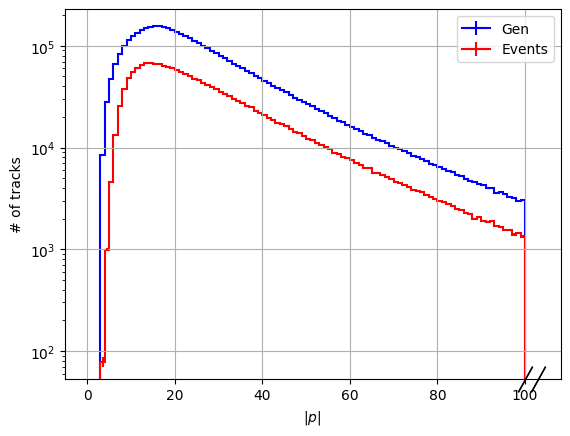

In [239]:
hMagGen.plot(color = "blue", label = "Gen")
hMagEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

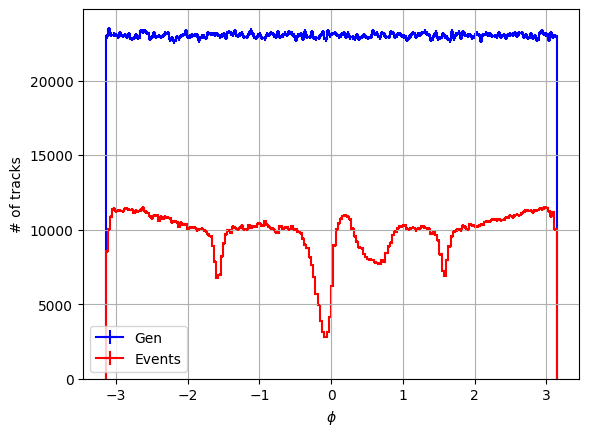

In [240]:
hPhiGen.plot(color = "blue", label = "Gen")
hPhiEvents.plot(color = "red", label = "Events")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

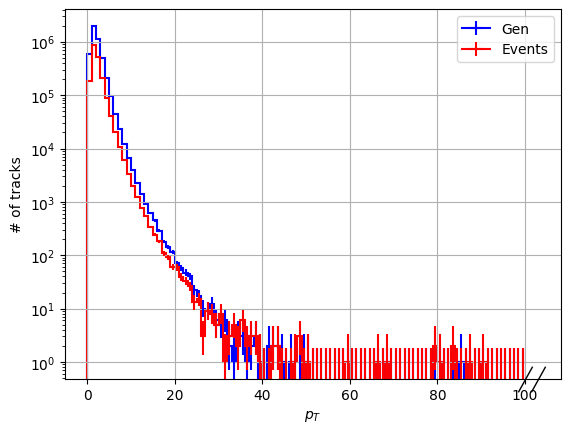

In [241]:
hPtGen.plot(color = "blue", label = "Gen")
hPtEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

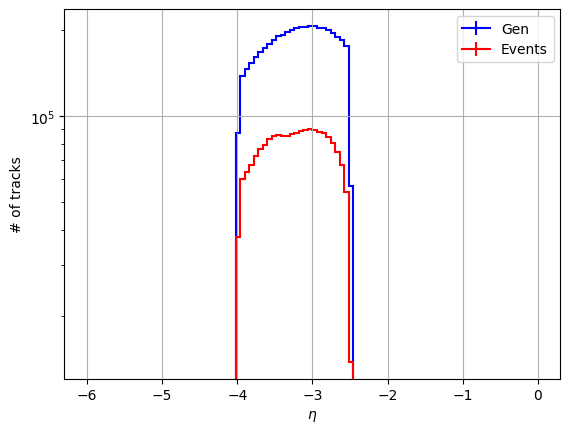

In [242]:
hEtaGen.plot(color = "blue", label = "Gen")
hEtaEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

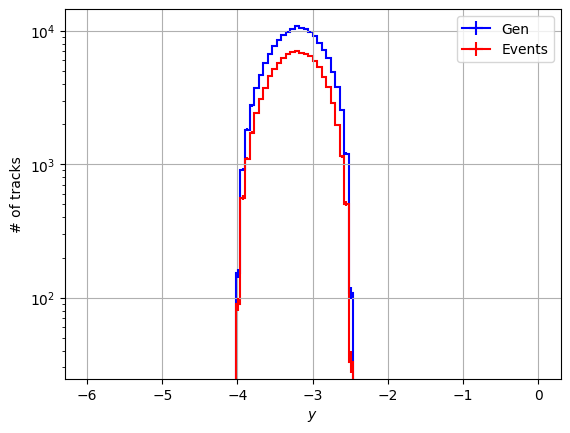

In [243]:
hYGen.plot(color = "blue", label = "Gen")
hYEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

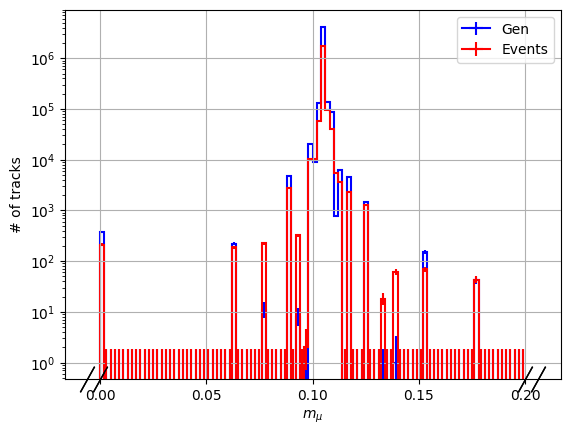

In [244]:
hMassGen.plot(color = "blue", label = "Gen")
hMassEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

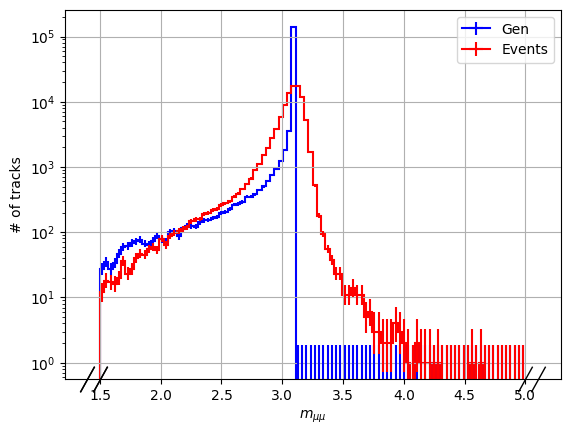

In [245]:
hMass2Gen.plot(color = "blue", label = "Gen")
hMass_OSEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

In [246]:
print(hMass_OSEvents.axes[0].centers.tolist())
print(hMass_OSEvents.view().tolist())
print(hMass2Gen.view().tolist())

[1.5174999999999998, 1.5525, 1.5875, 1.6225, 1.6574999999999998, 1.6925, 1.7275, 1.7625000000000002, 1.7975, 1.8325, 1.8675000000000002, 1.9025000000000003, 1.9375, 1.9725, 2.0075, 2.0425, 2.0775, 2.1125, 2.1475, 2.1825, 2.2175000000000002, 2.2525, 2.2875, 2.3225, 2.3575, 2.3925, 2.4275, 2.4625, 2.4975, 2.5324999999999998, 2.5675, 2.6025, 2.6375, 2.6725000000000003, 2.7075, 2.7424999999999997, 2.7775, 2.8125, 2.8475, 2.8825000000000003, 2.9175000000000004, 2.9524999999999997, 2.9875, 3.0225, 3.0575, 3.0925, 3.1275, 3.1625, 3.1975, 3.2325, 3.2675, 3.3025, 3.3375, 3.3725000000000005, 3.4074999999999998, 3.4425000000000003, 3.4775, 3.5125, 3.5475, 3.5824999999999996, 3.6174999999999997, 3.6525000000000003, 3.6875, 3.7224999999999997, 3.7575000000000003, 3.7925000000000004, 3.8275, 3.8625, 3.8975, 3.9324999999999997, 3.9675, 4.0024999999999995, 4.0375, 4.0725, 4.1075, 4.1425, 4.1775, 4.2125, 4.2475000000000005, 4.2825, 4.3175, 4.352499999999999, 4.3875, 4.422499999999999, 4.4575, 4.4925000